In [34]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalBoosting import MeanFieldVariationalMixtureDistribution
from Tools.NNtools import *

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [36]:
# load data and make it in proper shape
data = torch.load('Data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [37]:
model = nn.Sequential( nn.Linear(1, 50),
                       nn.Tanh(), 
                       nn.Linear(50, 1),
                     ).to(device)

In [38]:
param_count = get_param(model).shape[0]

In [39]:
flip_parameters_to_tensors(model)

In [40]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [41]:
def logprior(x):
    return prior.log_prob(x)

In [42]:
def loglikelihood(theta, model, x, y, sigma_noise):
    def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)
    #set_param(model, theta)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [43]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [44]:
def show_variational_posterior_predictive(q):
    x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample()
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [45]:
def MAP():
    theta = torch.nn.Parameter( prior.sample(), requires_grad=True)

    optimizer = torch.optim.Adam([theta], lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

    for t in range(1000):
        optimizer.zero_grad()

        L = -torch.mean(logposterior(theta, model, x_data, y_data, sigma_noise=0.1))
        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        optimizer.step()

        if learning_rate < 0.001:
            break
    return theta.detach().clone()

In [ ]:
eMAP = []
for k in range(10):
    print(k)
    theta = MAP()
    eMAP.append(theta)

In [131]:
import ray
import time
import setproctitle

# Start Ray.
ray.init()

2020-01-06 17:51:04,143	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-01-06 17:51:04,144	INFO resource_spec.py:216 -- Starting Ray with 92.72 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '192.168.1.197',
 'redis_address': '192.168.1.197:15215',
 'object_store_address': '/tmp/ray/session_2020-01-06_17-51-04_142451_28817/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-01-06_17-51-04_142451_28817/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-01-06_17-51-04_142451_28817'}

In [132]:
@ray.remote
def f(x):
    return MAP()

# Start 4 tasks in parallel.
result_ids = []
for i in range(100):
    result_ids.append(f.remote(i))

results = ray.get(result_ids)  # [0, 1, 2, 3]

In [133]:
results

[tensor([[-1.5422e+00, -6.2408e-01,  1.3819e-01, -1.7110e-01, -3.0452e-01,
          -1.3266e+00,  1.2344e-01,  1.8732e+00,  2.3662e-01,  1.3040e-01,
          -1.1370e+00, -1.2675e+00, -3.9273e-01,  7.8660e-01, -8.6898e-01,
          -7.2419e-03, -2.1624e+00,  1.9489e+00,  1.1649e-01,  1.0166e+00,
          -8.6850e-01, -2.1678e-01, -9.4972e-01, -1.2071e+00, -1.3618e+00,
           3.9225e-01, -9.0572e-01, -1.0897e-01, -1.8993e-02, -1.5424e+00,
           8.4936e-01,  6.1052e-01,  8.2815e-01,  5.7190e-01, -8.2065e-01,
           2.0585e+00,  2.3894e-01,  1.8453e+00, -9.1309e-01,  5.3007e-01,
          -6.3707e-01, -6.8914e-01, -2.4745e+00,  1.0199e+00,  2.1388e-01,
          -2.4623e-01, -1.3397e+00, -5.7028e-01, -6.6342e-01, -4.3099e-01,
          -1.0230e+00,  1.1168e-01,  5.5001e-01, -1.7788e-02, -9.4878e-02,
           1.6264e-01, -2.5684e-01,  7.3363e-01,  1.4723e-02, -3.5898e-01,
           3.8593e-01,  2.7651e-01,  6.8795e-01, -7.3000e-01, -8.8221e-01,
           1.6202e+00, -4

In [134]:
ray.shutdown()

In [208]:
eMAP = results

tensor([[-6.5013e+00, -5.2035e+00, -4.6010e-01, -4.5689e+00,  5.2646e+00,
          5.4214e+00, -8.5505e+00,  4.1419e+00,  4.6052e+00,  5.3892e+00,
          5.3870e-02, -2.6083e+00,  3.6871e+00, -3.5700e+00,  4.6266e+00,
         -6.3105e-03, -2.5395e+00,  1.6671e+00,  2.5006e-03, -6.6647e-03,
         -1.7347e-02, -1.7901e-02, -4.6132e-03, -2.1587e+00, -6.5670e-03,
          1.4902e-02,  9.9168e-01, -2.5624e-03, -7.0935e-03, -3.3457e+00,
         -6.1773e+00, -4.4730e+00, -2.3871e+00,  3.4300e+00,  1.5998e+00,
         -4.6391e-01, -3.8373e+00,  5.1487e+00,  4.5154e+00, -6.6666e-01,
         -1.8612e+00, -1.6767e-03, -2.7074e+00,  4.3520e+00,  2.4353e+00,
          9.5987e-03, -4.1368e+00, -5.2337e+00, -2.8315e+00, -1.8182e-02,
          6.7388e-01,  5.6073e-03, -3.1678e+00,  9.2952e-01,  6.0705e-02,
          4.2436e-02,  2.6323e-02, -2.5306e-02, -1.4931e-02,  5.3725e-04,
         -1.3740e+00,  7.3123e-02, -9.7286e-03, -4.3130e-02,  4.8138e+00,
          2.7792e+00,  1.3701e-02,  1.

In [209]:
components = []

In [210]:
for k in range(len(eMAP)):
    q_new = MeanFieldVariationalDistribution(param_count, sigma=0.001, device=device)
    q_new.mu = nn.Parameter(eMAP[k].squeeze(0).to(device), requires_grad=True) 
    components.append(q_new)

In [211]:
with torch.no_grad():
    proportions = torch.ones([len(eMAP)], requires_grad=True, device=device)/len(eMAP)

In [212]:
q = MeanFieldVariationalMixtureDistribution(proportions, components, device=device)

In [213]:
[c.rho.detach_().requires_grad_(True) for c in q.components]

[Parameter containing:
 tensor([-6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
         -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
         -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
         -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
         -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
         -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
         -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
         -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
         -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
         -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
         -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
         -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072, -6.9072,
     

In [214]:
[c.mu.detach_().requires_grad_(True) for c in q.components]

[Parameter containing:
 tensor([-6.5013e+00, -5.2035e+00, -4.6010e-01, -4.5689e+00,  5.2646e+00,
          5.4214e+00, -8.5505e+00,  4.1419e+00,  4.6052e+00,  5.3892e+00,
          5.3870e-02, -2.6083e+00,  3.6871e+00, -3.5700e+00,  4.6266e+00,
         -6.3105e-03, -2.5395e+00,  1.6671e+00,  2.5006e-03, -6.6647e-03,
         -1.7347e-02, -1.7901e-02, -4.6132e-03, -2.1587e+00, -6.5670e-03,
          1.4902e-02,  9.9168e-01, -2.5624e-03, -7.0935e-03, -3.3457e+00,
         -6.1773e+00, -4.4730e+00, -2.3871e+00,  3.4300e+00,  1.5998e+00,
         -4.6391e-01, -3.8373e+00,  5.1487e+00,  4.5154e+00, -6.6666e-01,
         -1.8612e+00, -1.6767e-03, -2.7074e+00,  4.3520e+00,  2.4353e+00,
          9.5987e-03, -4.1368e+00, -5.2337e+00, -2.8315e+00, -1.8182e-02,
          6.7388e-01,  5.6073e-03, -3.1678e+00,  9.2952e-01,  6.0705e-02,
          4.2436e-02,  2.6323e-02, -2.5306e-02, -1.4931e-02,  5.3725e-04,
         -1.3740e+00,  7.3123e-02, -9.7286e-03, -4.3130e-02,  4.8138e+00,
          2.779

In [215]:
q.proportions

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100])

# Variational Distribution #

In [201]:
n_samples_ELBO = 200

In [202]:
optimizer = torch.optim.Adam( [c.mu for c in q.components]+[c.rho for c in q.components], lr=0.01, betas=(0.999,0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.8)

In [203]:
#optimizer = torch.optim.Adam( [c.mu for c in q.components]+[c.rho for c in q.components]+[q.proportions], lr=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.5)

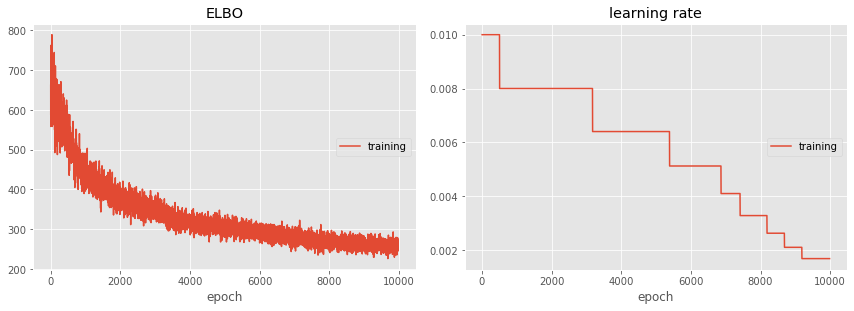

ELBO:
training   (min:  226.160, max:  794.440, cur:  251.175)

learning rate:
training   (min:    0.002, max:    0.010, cur:    0.002)


In [204]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    Ln = []
    Z = q.sample(n_samples_ELBO)
    MU = torch.stack([c.mu for c in q.components])
    SIGMA = torch.stack([c.sigma for c in q.components])
    A_ = -0.5*torch.log(2*np.pi*SIGMA**2)
    B_ = (SIGMA**2)
    for j in range(n_samples_ELBO):
        z = Z[j,:].unsqueeze(0)
        #LQ = q.log_prob(z)

        P = A_ - ( 0.5*(MU-z)**2)/B_ 
        LQ = torch.logsumexp(torch.log(q.proportions) + P.sum(dim=1), dim=0)
        
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        Ln.append(LQ - LP)

    L = torch.stack(Ln).mean()
    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 20 == 0:
        liveloss.draw()

    optimizer.step()
    
    with torch.no_grad():
        torch.abs_(q.proportions)
        q.proportions = q.proportions / q.proportions.sum()
    q.proportions.detach_().requires_grad_(True)

    if learning_rate < 0.001:
        break

In [205]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [206]:
q.proportions

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100], requires_grad=True)

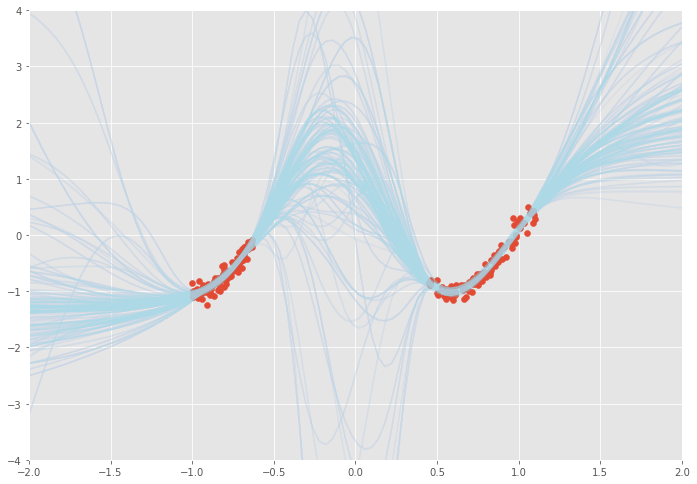

In [216]:
show_variational_posterior_predictive(q)

In [32]:
q.proportions

Parameter containing:
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000], requires_grad=True)

In [30]:
L = q.proportions.sum()

In [31]:
L.backward()

In [33]:
q.requires_grad

AttributeError: 'MeanFieldVariationalMixtureDistribution' object has no attribute 'requires_grad'

In [ ]:
Ln = []
Z = q.sample(n_samples_ELBO)
MU = torch.stack([c.mu for c in q.components])
SIGMA = torch.stack([c.sigma for c in q.components])
A_ = -0.5*torch.log(2*np.pi*SIGMA**2)
B_ = (SIGMA**2)
for j in range(n_samples_ELBO):
    z = Z[j,:].unsqueeze(0)
    #LQ = q.log_prob(z)

    P = A_ - ( 0.5*(MU-z)**2)/B_ 
    LQ = torch.logsumexp(torch.log(q.proportions) + P.sum(dim=1), dim=0)

    LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
    Ln.append(LQ - LP)

L = torch.stack(Ln).mean()
L.backward()